# Introduction
This is the NUS DSA5105 course project. I finished several tasks on CIFAR-10 dataset.

The `.ipynb` file includes 3 parts:
- **CIFAR-10 Dataset Overview**
    - Introduction of the dataset
    - Visualization of the dataset
    - K-fold dataloader for the dataset
- **Supervised Learning**:
    - Logistic Regression
    - Random Forest
    - Convolutional Nearual Network
- **Unsupervised Learning**:
    - Autoencoder
    - KMeans Clustering
    - Autoencoder + KMeans

And I used k-fold cross validation in `Logistic Regression` and `Convolutional Nearual Network` parts to evaluate the model performance.

The dataset is in "`./data`" and all of the trained model are in "`./model`", and I have annotated all the code for the training section, if you have downloaded the `./model` folder, you can run each code block within 30 seconds.

You can also get the project file on [GitHub](https://github.com/Mahlesurrection/DSA5105_Project).


# CIFAR-10 Dataset Overview

The CIFAR-10 dataset is a widely used dataset for machine learning and computer vision tasks. It was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton.

## Key Details

- **Number of Images**: 60,000
- **Dimensions**: 32x32 (width x height)
- **Channels**: 3 (RGB)
- **Classes**: 10
- **Images per Class**: 6,000
- **Training Set Size**: 50,000 images
- **Test Set Size**: 10,000 images
- **Class Labels**:
  - airplane
  - automobile
  - bird
  - cat
  - deer
  - dog
  - frog
  - horse
  - ship
  - truck

## Dataset Purpose

The CIFAR-10 dataset is primarily used for training and testing machine learning models, particularly in the field of image recognition.

## Image Characteristics

- **Resolution**: Low (32x32), leading to a challenging pattern recognition task.
- **Variety**: Images are taken from various angles and lighting conditions.
- **Labeling**: Each image is labeled with one of the 10 class labels.

## Usage

CIFAR-10 is widely used for benchmarking image classification algorithms due to its manageable size and its complexity that is sufficient to evaluate the performance of various algorithms.

## Access

The dataset can be accessed and downloaded from the CIFAR dataset website or through various data science and machine learning libraries, such as TensorFlow and PyTorch.


### Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns

import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

from tqdm import tqdm

### Dataloader

In [2]:
def GetLoader(batch_size = 128, transform=[]):
    # define the transform so that data is in [0, 1]
    transform = transforms.Compose(
        [transforms.ToTensor()
        ])
    # load training set
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=2)

    # load test set
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=5000,
                                            shuffle=False, num_workers=2)

    # CIFAR-10 classes
    classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    return trainloader, testloader, classes

In [3]:
# generate dataloader for K-fold cross validation
def get_k_fold_data_loaders(batch_size, k, current_fold, transform):
    # load the dataset
    dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
    
    # Length of dataset
    dataset_size = len(dataset)
    
    # Shuffle dataset indices
    indices = list(range(dataset_size))
    np.random.shuffle(indices)
    
    # Calculate the size of a single fold
    fold_size = dataset_size // k
    
    # Split indices into k folds
    folds = [indices[i * fold_size:(i + 1) * fold_size] for i in range(k)]
    
    # Concatenate the indices of the other folds to use as training data
    train_indices = [idx for i in range(k) if i != current_fold for idx in folds[i]]
    
    # The current fold is used as the validation set
    valid_indices = folds[current_fold]
    
    # Create samplers for training and validation folds
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(valid_indices)
    
    # Create data loaders for training and validation
    trainloader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
    validloader = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=2)
    
    return trainloader, validloader

## Visulization

Files already downloaded and verified
Files already downloaded and verified


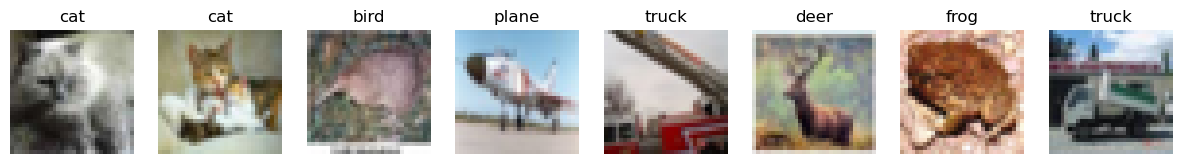

In [4]:
# Function to show images with labels beneath each image
def imshow_with_labels(img, labels, classes):
    # Get the number of images
    num_images = len(labels)
    # Set the titles with class labels
    titles = [classes[labels[j]] for j in range(num_images)]
    # Create a grid with titles beneath each image
    fig, axes = plt.subplots(1, num_images, figsize=(15, 2))
    for ax, title, image in zip(axes, titles, images):
        ax.imshow(np.transpose(image.numpy(), (1, 2, 0)))
        ax.set_title(title)
        ax.axis('off')  # Hide the axes
    plt.show()

# Get some random training images
trainloader, _, classes = GetLoader(8)
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images with labels beneath
imshow_with_labels(torchvision.utils.make_grid(images, nrow=4), labels, classes)

# Supervised Learning

## Image Classification on CIFAR-10 Dataset

Image classification is a core task in the field of computer vision. The CIFAR-10 dataset presents a benchmark challenge for this task due to its diverse set of low-resolution images.

### Task Description

- **Objective**: The primary objective in the CIFAR-10 image classification task is to correctly identify which of the 10 classes a given image belongs to.
- **Input**: A 32x32 pixel image with 3 color channels (red, green, blue).
- **Output**: A single label from one of the 10 classes.

### Classes

The CIFAR-10 dataset contains images from 10 different classes, which represent a broad range of objects:

1. Airplane
2. Automobile
3. Bird
4. Cat
5. Deer
6. Dog
7. Frog
8. Horse
9. Ship
10. Truck

### Supervised Learning Approach

- **Training**: Models are trained using 50,000 labeled images. Each image comes with a corresponding class label.
- **Validation**: Typically, a portion of the training set is held out to form a validation set for hyperparameter tuning and model selection.
- **Testing**: After training, models are evaluated on a separate set of 10,000 labeled images to gauge their performance.

### Performance Metrics

- **Accuracy**: The most common metric used for this task is classification accuracy, the percentage of images correctly classified.

### Challenges

- **Resolution**: The low resolution of images (32x32 pixels) makes it difficult for models to extract fine details.
- **Inter-class Variation**: Some classes have higher intra-class variation which can make accurate classification more challenging.

### Model Architectures

A wide variety of model architectures have been applied to this task, ranging from classical machine learning models to advanced deep learning networks such as CNNs (Convolutional Neural Networks).

### Tools and Libraries

- **TensorFlow**: Offers high-level APIs for building and training models on CIFAR-10.
- **PyTorch**: Another popular library that provides tools for loading CIFAR-10 and building neural networks.

By using CIFAR-10 for image classification, researchers and practitioners can benchmark their algorithms against a standard and challenging dataset to assess their models' ability to generalize from visual data.


## CIFAR-10 Classification Using Logistic Regression

Logistic regression, traditionally a linear model for binary classification, can be adapted for the multi-class classification task of the CIFAR-10 dataset.

### Logistic Regression Overview

Logistic regression models the probabilities of a default class (typically "1") and its complement (typically "0"). For multi-class problems like CIFAR-10, the technique is extended into what is known as "one-vs-rest" logistic regression.

#### CIFAR-10 Dataset

- **Size**: 32x32 pixel images
- **Channels**: 3 (RGB)
- **Classes**: 10 distinct categories

### Implementation Steps

1. **Preprocessing**:
   - Flatten the images from a 3D tensor of 32x32x3 to a 1D tensor of 3072 pixels.
   - Normalize the pixel values for better convergence during training.

2. **Model Architecture**:
   - Input Layer: 3072 input features corresponding to the pixel values of the images.
   - Output Layer: 10 units, each representing one of the CIFAR-10 classes.

3. **Training**:
   - Use softmax as the activation function in the output layer to handle multiple classes.
   - Apply cross-entropy as the loss function.
   - Utilize gradient descent or more advanced optimizers like `SGD` or `Adam` to minimize the loss.

4. **Evaluation**:
   - Determine the accuracy of the model on the test dataset.
   - Analyze the results using a confusion matrix.

### Challenges with Logistic Regression for CIFAR-10

- **Computational Complexity**: Due to the high dimensionality of the input features, the model can be computationally intensive.
- **Linear Boundaries**: Logistic regression assumes linear boundaries, which may not be sufficient for the complex patterns in CIFAR-10 images.

### Extensions to Improve Performance

- **Feature Engineering**: Use dimensionality reduction techniques or feature extraction methods to reduce complexity and potentially improve model performance.
- **Regularization**: Apply L1 or L2 regularization to prevent overfitting.

In [5]:
# Logistic regression model
class LogisticRegressionModel(nn.Module):
    def __init__(self):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(3072, 10)  # CIFAR-10 image:3x32x32=3072
        self.sm = nn.Sigmoid()  # sigmoid function

    def forward(self, x):
        x = x.reshape(x.size(0), -1)  # flatten the image
        x = self.linear(x)
        x = self.sm(x)
        return x

In [6]:
def train_logistic(model, Loss, optimizer, epochs, train_loader, order=0):
    for epoch in tqdm(range(epochs)): 
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()  # clear gradients
            output = model(data)  # forward propagation
            loss = Loss(output, target)  # loss
            loss.backward()  # back propagation
            optimizer.step()  # update parameters
            
            # if batch_idx % 50 == 0:
            #     print(f"Train Epoch: {epoch + 1} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
    #save model
    if order == 0:
        torch.save(model.state_dict(), './model/logistic_model_state_dict.pth')
    else:
        torch.save(model.state_dict(), f'./model/logistic_model_state_dict_fold_{order}.pth')
    return model

# test the model
def evalModel(model, Loss, testloader, order=0):
    model.eval()  # set the model to evaluation mode
    test_loss = 0
    correct = 0
    num = 0
    with torch.no_grad():  # no gradient calculation
        for data, target in testloader:
            num += target.shape[0]
            output = model(data)
            test_loss += Loss(output, target).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()

    test_loss /= num
    if order == 0:
        print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{num} ({100. * correct / num:.0f}%)\n')
    else:
        print(f'\nFold {order}: Average loss: {test_loss:.4f}, Accuracy: {correct}/{num} ({100. * correct / num:.0f}%)\n')

### Training Logistic Regression with K-Fold Cross-Validation

K-fold cross-validation is a statistical method used to estimate the skill of machine learning models. It is particularly useful when performing hyperparameter tuning and model selection. When used in conjunction with logistic regression, it can help ensure that the model does not overfit to a particular subset of the data.

#### Overview of K-Fold Cross-Validation

- **Partitioning**: The data is randomly partitioned into `k` equal-sized subsamples.
- **Validation**: Out of the `k` subsamples, a single subsample is retained as the validation data for testing the model, and the remaining `k-1` subsamples are used as training data.
- **Iteration**: The cross-validation process is then repeated `k` times (the folds), with each of the `k` subsamples used exactly once as the validation data.
- **Aggregation**: The `k` results can then be averaged to produce a single estimation.

#### Steps for K-Fold Cross-Validation with Logistic Regression

1. **Data Preparation**:
   - Preprocess the data as required for logistic regression, such as scaling or encoding categorical variables.

2. **K-Fold Setup**:
   - Decide on the number of folds (`k`), here we choose $k=5$. Common choices are 5 or 10 for a balance between variance and bias.

3. **Model Training and Evaluation**:
   - For each fold, train the logistic regression model on the `k-1` training folds and evaluate it on the validation fold.
   - Collect the model's performance metrics for each fold, typically accuracy or area under the ROC curve.

4. **Result Aggregation**:
   - Aggregate the performance across all `k` folds to get an overall performance metric.
   - This helps in assessing the model's generalization performance.

5. **Hyperparameter Tuning**:
   - K-fold cross-validation can be nested with hyperparameter tuning algorithms like grid search or random search to find the optimal settings for the model.


#### K-fold cross validation

In [7]:
batch_size = 128
learning_rate = 0.01
epochs = 10
k = 5  # Number of folds
# define the transform so that data is in [0, 1]
transform = transforms.Compose([transforms.ToTensor()])
for fold in range(k):
    print(f'Fold {fold + 1}:')
    trainloader, validloader = get_k_fold_data_loaders(batch_size=128, k=k, current_fold=fold, transform=transform)
    # train the model on the trainloader and validate on the validloader
    # define model
    model = LogisticRegressionModel()

    # loss function and optimizer
    Loss = nn.CrossEntropyLoss(reduction='sum')
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    # model = train_logistic(model, Loss, optimizer, epochs, trainloader, fold + 1)

    model = LogisticRegressionModel()
    model.load_state_dict(torch.load(f'./model/logistic_model_state_dict_fold_{fold + 1}.pth'))
    evalModel(model, Loss, validloader, fold + 1)

Fold 1:

Fold 1: Average loss: 1.9911, Accuracy: 3742/10000 (37%)

Fold 2:

Fold 2: Average loss: 1.9957, Accuracy: 3727/10000 (37%)

Fold 3:

Fold 3: Average loss: 1.9917, Accuracy: 3553/10000 (36%)

Fold 4:

Fold 4: Average loss: 1.9934, Accuracy: 3726/10000 (37%)

Fold 5:

Fold 5: Average loss: 1.9932, Accuracy: 3733/10000 (37%)



Training using the whole training set.
The accuracy turns out to be 37%.

In [8]:
# Hyperparameters
batch_size = 128
learning_rate = 0.01
epochs = 20
train_loader, test_loader, classes = GetLoader(batch_size)

# define model
model = LogisticRegressionModel()

# loss function and optimizer
Loss = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# train the model
# model = train_logistic(model, Loss, optimizer, epochs, train_loader)

#load model
model = LogisticRegressionModel()
model.load_state_dict(torch.load('./model/logistic_model_state_dict.pth'))
evalModel(model, Loss, test_loader, order = 0)

Files already downloaded and verified
Files already downloaded and verified

Test set: Average loss: 1.9968, Accuracy: 3710/10000 (37%)



## CIFAR-10 Classification Using Random Forest

Random Forest is an ensemble learning method that operates by constructing multiple decision trees during training time and outputting the class that is the mode of the classes (classification) of the individual trees.

### Overview of Random Forest

- **Ensemble Method**: Combines predictions from multiple machine learning algorithms to make more accurate predictions than any individual model.
- **Decision Trees**: Random Forest builds multiple decision trees and merges them together to get a more accurate and stable prediction.
- **Robust to Overfitting**: Due to the averaging of results, Random Forest can be less prone to overfitting than a single decision tree.

### CIFAR-10 Dataset

- **Size**: 32x32 pixel images
- **Channels**: 3 (RGB)
- **Classes**: 10 distinct categories, ranging from animals to vehicles.

### Implementation Steps

1. **Preprocessing**:
   - Convert images to grayscale to reduce complexity (optional).
   - Flatten the images from a 3D tensor of 32x32x3 to a 1D tensor.
   - Normalize or scale the pixel values.

2. **Random Forest Classifier**:
   - Use an ensemble of decision trees to classify the images.
   - Configure hyperparameters like the number of trees in the forest and the depth of each tree.

3. **Training the Classifier**:
   - Train the Random Forest on the flattened and preprocessed training data.
   - Use cross-validation to avoid overfitting and tune hyperparameters.

4. **Evaluation**:
   - After training, test the classifier on unseen data and measure its performance.
   - Metrics such as accuracy, precision, recall, and F1 score can be used for evaluation.

### Challenges

- **High Dimensionality**: The flattened images result in a high-dimensional feature space, which can be computationally intensive for a Random Forest.
- **Data Reduction**: Some information loss might occur due to image flattening or grayscaling.

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from torchvision.datasets import CIFAR10
import numpy as np
from torchvision.transforms import ToTensor

# load CIFAR-10 dataset
train_data = CIFAR10(root="./data", train=True, download=False, transform=ToTensor())
test_data = CIFAR10(root="./data", train=False, download=False, transform=ToTensor())

# Transform the data to numpy array
X_train = train_data.data.reshape((len(train_data), 3072))  # flatten the image
y_train = np.array(train_data.targets)
X_test = test_data.data.reshape((len(test_data), 3072))
y_test = np.array(test_data.targets)

# create a random forest classifier
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

In [10]:
# # train the model
# rf.fit(X_train, y_train)

Training using the whole training set.
The accuracy turns out to be 46.65%.

In [11]:
from joblib import dump
from joblib import load
# dump(rf, './model/random_forest_cifar10.joblib')
rf = load('./model/random_forest_cifar10.joblib')
# Make predictions
y_pred = rf.predict(X_test)

# evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy * 100:.2f}%")

Model accuracy: 46.65%


## CIFAR-10 Classification Using Convolutional Neural Networks (CNNs)

Convolutional Neural Networks (CNNs) are highly effective for image classification tasks, including the CIFAR-10 dataset, which consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class.

### CNN Architecture for CIFAR-10

A CNN for CIFAR-10 typically comprises several layers, including:

- **Convolutional Layers**: To extract spatial hierarchy of features from the images.
- **Activation Functions**: Such as ReLU, to introduce non-linearity into the model.
- **Pooling Layers**: To reduce the spatial size of the representation, reducing the number of parameters and computation in the network.
- **Fully Connected Layers**: A final set of layers where each neuron is connected to every neuron in the previous layer to classify the features extracted by the convolutional layers.
- **Output Layer**: With a softmax activation function to obtain the probability distribution over the 10 classes.

### Training a CNN on CIFAR-10

The training process includes the following steps:

1. **Preprocessing**:
   - Normalize the image pixel values.
   - Optionally augment the data to prevent overfitting and improve generalization.

2. **Model Compilation**:
   - Choose a loss function, like categorical cross-entropy for multi-class classification.
   - Select an optimizer, such as Adam or SGD with momentum.

3. **Model Training**:
   - Use backpropagation and the chosen optimization algorithm to train the model.
   - Validate the model after each epoch to monitor performance and prevent overfitting.

4. **Performance Evaluation**:
   - After training, evaluate the model on the test set.
   - Measure accuracy, precision, recall, F1 score, and other relevant metrics.

Define CNN framework, train and eval function.

In [12]:
# define the CNN model
class CNN_Net(nn.Module):
    def __init__(self):
        super(CNN_Net, self).__init__()
        # convolutional layer
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
        # fully connected layers
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # convolutional layers with max pooling
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        # flatten the image
        x = x.view(-1, 64 * 4 * 4)
        # fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [13]:
def train_cnn(net, Loss, optimizer, epochs, train_loader, device, order=0):
    for epoch in tqdm(range(epochs)):  # epochs
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # Send inputs and labels to the device
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()

            outputs = net(inputs)
            loss = Loss(outputs, labels)
            loss.backward()
            optimizer.step()
            
            if order == 0:
                running_loss += loss.item()
                if i % 200 == 199:
                    print('[%d, %5d] loss: %.3f' %
                        (epoch + 1, i + 1, running_loss / 200))
                    running_loss = 0.0
    if order == 0:
        torch.save(net.state_dict(), './model/cnn_model_state_dict.pth')
    else:
        torch.save(net.state_dict(), f'./model/cnn_model_state_dict_fold_{order}.pth')
    # Move the model back to CPU
    net.to('cpu')
    return net

# evaluate the model
def evalCNNModel(model, test_loader, order=0):
    model.eval()  # set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    if order == 0:
        print('Accuracy of the network on the 10000 test images: %d %%' % (
            100 * correct / total))
    else:
        print(f'Accuracy of the network on the {order}-fold\'s {total} validation images: %d %%' % (
            100 * correct / total))

### Training CNNs with K-Fold Cross-Validation

K-fold cross-validation is a technique used to evaluate predictive models by partitioning the original sample into a set of k equally sized folds, training the model on k-1 folds, and validating it on the remaining part of the data.

#### Applying K-Fold Cross-Validation to CNNs

##### Step 1: Data Preparation

- Start by preprocessing images as required by the CNN, including normalization and resizing.
- Optionally, augment your training data to introduce variability, which can help improve model robustness.

##### Step 2: Define the CNN Architecture

- Define CNN architecture with convolutional layers, activation functions, pooling layers, and fully connected layers.
- Ensure the output layer has the appropriate activation function, like softmax for multi-class classification tasks.

##### Step 3: K-Fold Cross-Validation Loop

- Split the dataset into `k` folds using stratified sampling to maintain the distribution of classes within each fold.
- Initialize the model inside the loop so that each fold gets a fresh model without any learned weights from the previous folds.

##### Step 4: Training and Validation

- For each iteration, train the CNN on the `k-1` training folds.
- Validate the CNN on the remaining fold and record the performance metrics.
- After the completion of `k` iterations, average out the performance metrics to get a final model performance score.

##### Step 5: Hyperparameter Tuning and Model Selection

- Use the validation scores from k-fold cross-validation to tune the model's hyperparameters.
- Select the model that performs best on average across all k folds.

In [14]:
# Check for GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Training on {device}')

Training on cuda:0


In [21]:
batch_size = 128
learning_rate = 0.01
epochs = 50
k = 5  # Number of folds
# define the transform so that data is in [0, 1]
transform = transforms.Compose([transforms.ToTensor()])
for fold in range(k):
    print(f'Fold {fold + 1}:')
    trainloader, validloader = get_k_fold_data_loaders(batch_size=batch_size, k=k, current_fold=fold, transform=transform)
    # train the model on the trainloader and validate on the validloader
    
    # define model and hyperparameters
    # loss function, optimizer and net
    Loss = nn.CrossEntropyLoss()
    net = CNN_Net()
    # optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    # # Move the model to the specified device
    # net.to(device)

    # # train the model
    # model = train_cnn(net, Loss, optimizer, epochs, trainloader, device, fold + 1)

    model = CNN_Net()
    model.load_state_dict(torch.load(f'./model/cnn_model_state_dict_fold_{fold + 1}.pth'))
    evalModel(model, Loss, validloader, fold + 1)

Training on cuda:0
Fold 1:


100%|██████████| 50/50 [09:25<00:00, 11.31s/it]



Fold 1: Average loss: 0.0179, Accuracy: 7080/10000 (71%)

Fold 2:


100%|██████████| 50/50 [09:04<00:00, 10.90s/it]



Fold 2: Average loss: 0.0195, Accuracy: 6920/10000 (69%)

Fold 3:


100%|██████████| 50/50 [09:04<00:00, 10.89s/it]



Fold 3: Average loss: 0.0179, Accuracy: 6918/10000 (69%)

Fold 4:


100%|██████████| 50/50 [09:07<00:00, 10.95s/it]



Fold 4: Average loss: 0.0181, Accuracy: 7041/10000 (70%)

Fold 5:


100%|██████████| 50/50 [09:07<00:00, 10.96s/it]



Fold 5: Average loss: 0.0183, Accuracy: 7120/10000 (71%)



Training using the whole training set.
The accuracy turns out to be 72%.

In [15]:
# Hyperparameters
batch_size = 128
learning_rate = 0.001
epochs = 50
train_loader, test_loader, classes = GetLoader(batch_size)

# define model
model = CNN_Net()
# Move the model to the specified device
model.to(device)

# loss function, optimizer
Loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# # train the model
# model = train_cnn(model, Loss, optimizer, epochs, train_loader, device)

#load model
model = CNN_Net()
model.load_state_dict(torch.load('./model/cnn_model_state_dict.pth'))
evalModel(model, Loss, test_loader, order = 0)

Files already downloaded and verified
Files already downloaded and verified

Test set: Average loss: 0.0004, Accuracy: 7233/10000 (72%)



## CIFAR-10 Classification Results Comparison

We have performed the CIFAR-10 image classification task using three different machine learning models: Logistic Regression, Random Forest, and a Convolutional Neural Network (CNN). The results are summarized below in terms of accuracy.

### Models and Accuracy

#### Logistic Regression

- **Description**: A simple linear model used for binary classification tasks, extended for the multi-class setting.
- **CIFAR-10 Accuracy**: 37%

#### Random Forest

- **Description**: An ensemble learning method that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes of the individual trees.
- **CIFAR-10 Accuracy**: 46.65%

#### Convolutional Neural Network (CNN)

- **Description**: A deep learning algorithm which can take in an input image, assign importance (learnable weights and biases) to various aspects/objects in the image, and be able to differentiate one from the other.
- **CIFAR-10 Accuracy**: 72%

### Discussion

The accuracy results indicate a clear trend in performance with respect to the complexity of the models. Logistic Regression, being a linear model, has the lowest accuracy since it struggles with the complex patterns and nuances in the CIFAR-10 dataset. Random Forest improves on Logistic Regression due to its ability to capture non-linear patterns by leveraging multiple decision trees. However, the CNN outperforms both Logistic Regression and Random Forest by a significant margin. The inherent design of CNNs to capture spatial hierarchies in image data makes it particularly well-suited for image classification tasks like CIFAR-10.

### Conclusion

The comparison shows that model choice plays a crucial role in the performance of image classification tasks. While Logistic Regression and Random Forest can serve as baseline models, CNNs are preferable for higher accuracy in complex image classification challenges like those presented by the CIFAR-10 dataset.


# Unsupervised Learning

## Encoding and Decoding CIFAR-10 Images Using Autoencoders

Autoencoders are a type of neural network used to learn efficient representations (encodings) of unlabeled data, typically for the purpose of dimensionality reduction. An autoencoder learns to compress the data into an encoded representation and then reconstructs the data back from the reduced encoded form.

### Overview of Autoencoders

Autoencoders consist of two main parts:
- **Encoder**: This part of the network compresses the input into a latent-space representation. It defines how the input data is reduced to an encoding.
- **Decoder**: This part of the network reconstructs the input data from the latent space representation. It outlines how the data is reconstructed from the encoding.

### Applying Autoencoders to CIFAR-10

#### Step 1: Preprocessing the Data

Before feeding the data into the autoencoder, it's crucial to preprocess it:
- Normalize the pixel values to the range [0, 1].
- Flatten the images if you're using a fully connected autoencoder, or keep the images in their 3D shape (channels, width, height) if you're using a convolutional autoencoder.

#### Step 2: Defining the Autoencoder Architecture

For CIFAR-10, a convolutional autoencoder is more suitable due to its ability to work with image data effectively:
- The encoder might consist of a series of convolutional layers and pooling layers to reduce the spatial dimensions.
- The decoder would consist of a series of upsampling and convolutional layers to reconstruct the original image dimensions.

In [16]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(3 * 32 * 32, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 64)  # encoded feature is 64-dim
        )
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 3 * 32 * 32),
            nn.Sigmoid()  # to get the output in [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [17]:
# transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # 将图像展平
])

train_loader, _, _ = GetLoader(batch_size=64, transform=transform)

# define model
autoencoder = Autoencoder()

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

Files already downloaded and verified
Files already downloaded and verified


### Step 3: Training the Autoencoder

- Compile the autoencoder using an optimizer like Adam and a loss function like mean squared error (MSE), which is common for reconstruction tasks.
- Train the autoencoder using the CIFAR-10 images as both the inputs and the targets.

The code below is the training process of AutoEncoder, since we saved a trained model, I exegesised this block.

In [18]:
# # train the model
# num_epochs = 50

# for epoch in range(num_epochs):
#     for data in train_loader:
#         imgs, _ = data
#         imgs = imgs.reshape(imgs.size(0), -1)
#         outputs = autoencoder(imgs)
#         loss = criterion(outputs, imgs)
        
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#     print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

In [19]:
# # save the model
# torch.save(autoencoder.state_dict(), './model/autoencoder_model_state_dict.pth')

# load the model
autoencoder = Autoencoder()
autoencoder.load_state_dict(torch.load('./model/autoencoder_model_state_dict.pth'))

<All keys matched successfully>

#### Step 4: Encoding and Decoding Images

- Once trained, use the encoder to compress CIFAR-10 images into a lower-dimensional representation.
- Use the decoder to reconstruct the images from their encoded representations.

In [20]:
# get a image from test set
train_loader, test_loader, _ = GetLoader(batch_size=5, transform=transform)
def get_img(testloader):
    for data in testloader:
        imgs, _ = data
        imgs = imgs.reshape(imgs.size(0), -1)
        yield imgs

# define a function that plot the reconstructed images and their ground truths (inputs)
def Plot_img(autoencoder, imgs):
    outputs = autoencoder(imgs)
    plot_img = outputs[0].reshape(3, 32, 32).detach().numpy()
    plt.imshow(np.transpose(plot_img, (1, 2, 0)))
    plt.show()
    plot_img = imgs[0].reshape(3, 32, 32).detach().numpy()
    plt.imshow(np.transpose(plot_img, (1, 2, 0)))
    plt.show()

Files already downloaded and verified
Files already downloaded and verified


Plot the reconstructed images and their ground truths (inputs) from the training set


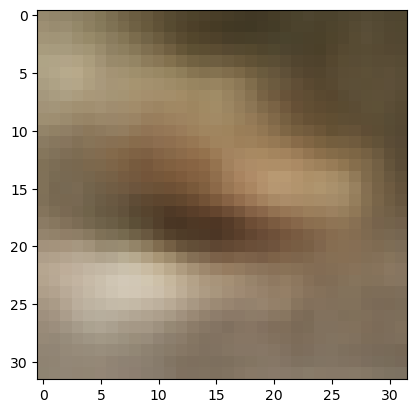

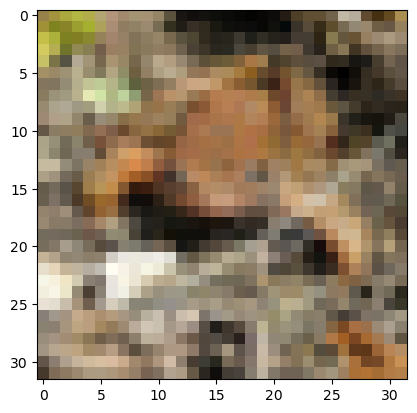

Plot the reconstructed images and their ground truths (inputs) from the test set


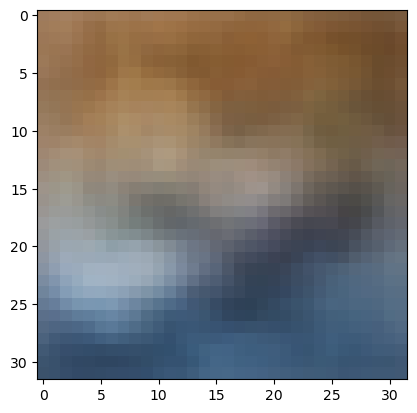

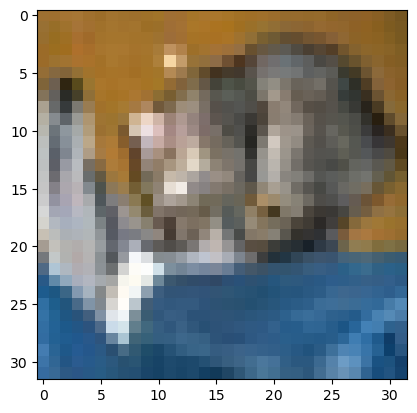

In [21]:
# plot the reconstructed images and their ground truths (inputs) from the training set
print('Plot the reconstructed images and their ground truths (inputs) from the training set')
Plot_img(autoencoder, next(get_img(train_loader)))
# plot the reconstructed images and their ground truths (inputs) from the test set
print('Plot the reconstructed images and their ground truths (inputs) from the test set')
Plot_img(autoencoder, next(get_img(test_loader)))

### Analysis of Autoencoder Compression on CIFAR-10 Images

Autoencoders serve as a powerful tool for learning efficient representations of data. In the context of CIFAR-10, an autoencoder can compress a 3x32x32 image down to a latent space of 64 dimensions and then reconstruct it back to its original size.

#### Compression and Reconstruction

- **Compression**: The encoder part of the network reduces the dimensionality of the image from 3072 pixels to a 64-dimensional encoding. This process captures the most significant features of the data while losing some details.
- **Reconstruction**: The decoder part attempts to reconstruct the image from the 64-dimensional encoding. The reconstructed image often appears blurrier than the original due to the loss of detail during compression.

#### Color Distribution

- Despite the loss of fine details and the resulting blur in the reconstructed images, the color distribution remains relatively consistent with the original images. This indicates that the encoder is effectively capturing the overall color scheme of the image in the compressed representation.

#### Improving the Autoencoder

- **Decoder Capacity**: By increasing the capacity of the decoder—adding more layers or neurons—the network can learn a more complex function to better reconstruct the details and sharpness of the original image.
- **Encoder-Decoder Symmetry**: It is generally beneficial to have a symmetric structure, where the capacity of the decoder matches the encoder, to maintain the balance in the network's ability to compress and reconstruct.

#### Autoencoders as a Compression Mechanism

- The ability of autoencoders to capture the essential characteristics of images in a smaller number of dimensions makes them a viable approach for image compression.
- The key advantage of using autoencoders over traditional compression algorithms is that they can be trained specifically for a certain type of image, potentially leading to better quality for that domain.

#### Conclusion

While the current autoencoder model compressing CIFAR-10 images to a 64-dimensional space produces somewhat blurry reconstructions, it preserves the overall color distribution effectively. Enhancing the decoder's architecture could yield sharper images and demonstrates the potential of autoencoders as an effective means for image compression. Further research and experimentation can explore the optimal balance between compression and reconstruction quality.



## Clustering CIFAR-10 with KMeans

Clustering is an unsupervised learning technique used to group data points into clusters based on feature similarity. KMeans is one of the most popular clustering algorithms, and we have applied it to the CIFAR-10 dataset, which consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class.

### Overview of KMeans

KMeans clustering aims to partition `n` observations into `k` clusters in which each observation belongs to the cluster with the nearest mean, serving as a prototype of the cluster.

### Applying KMeans to CIFAR-10

#### Preprocessing

Before applying KMeans, the CIFAR-10 images need to be preprocessed:
- **Normalization**: Scale pixel values to a range of [0, 1] for uniformity.
- **Flattening**: Transform the 2D image arrays into 1D feature vectors to fit the KMeans algorithm's expectations.

#### Initializing KMeans

We initialize KMeans with a specified number of clusters (`k`). For CIFAR-10, we may start with `k=10` to match the number of classes.

#### Clustering Process

The KMeans algorithm iteratively performs the following steps:
- **Assignment step**: Assign each image to the nearest cluster centroid.
- **Update step**: Calculate new cluster centroids based on the assignments.

#### Evaluating Clusters

With clustering, we can use several metrics to evaluate the quality of our clusters:
- **Inertia**: The sum of squared distances of samples to their closest cluster center.
- **Silhouette Score**: A measure of how similar an object is to its own cluster compared to other clusters.

#### Post-processing

After clustering, we might analyze the centroids to understand the common features within each cluster.

### Clustering Results and Purity

We evaluate the purity of each cluster, which measures the proportion of the dominant class in each cluster:
- Cluster purity varies, indicating the mixed quality of clusters.

### Conclusion

Applying KMeans to CIFAR-10 offers insights into the dataset's structure. However, due to the algorithm's simplicity and the complexity of the images, further techniques such as dimensionality reduction or feature extraction are recommended to improve clustering performance.


In [55]:
from sklearn.cluster import KMeans

# transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # 将图像展平
])

_, test_loader, _ = GetLoader(batch_size=64, transform=transform)

# load the autoencoder we trained on CIFAR-10
autoencoder = Autoencoder()
autoencoder.load_state_dict(torch.load('./model/autoencoder_model_state_dict.pth'))

# Compress the test images
compressed_images = []
labels = []
for data in test_loader:
    images, label = data
    images = images.reshape(images.size(0), -1)
    # compressed = autoencoder.encoder(images).detach().numpy()  # Use .detach() to avoid tracking history in autograd
    # compressed_images.append(compressed)
    compressed_images.append(images)
    labels.append(label)

compressed_images = np.vstack(compressed_images)  # Combine batches
labels = np.hstack(labels)


kmeans = KMeans(n_clusters=10)
clusters = kmeans.fit_predict(compressed_images)

Files already downloaded and verified
Files already downloaded and verified


c:\ProgramData\anaconda3\envs\intel_comp\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### Purity Metric for Clustering Evaluation
Although KNN is usually unsupervised learning, we can still measure the clustering result using the labels here.

Purity is an external evaluation metric for the quality of a clustering algorithm. It is a simple and transparent measure that assesses the extent to which clusters contain a single class of data.

#### How Purity is Calculated

The calculation of purity follows these steps:

1. **Assigning the Most Frequent Class**: Within each cluster, identify the most frequent class of data points.
2. **Cluster Purity**: The purity of the cluster is the proportion of the majority class in the cluster to the total number of data points in that cluster.
3. **Summation**: Sum the counts of the majority class for all clusters.
4. **Normalization**: Divide the summation by the total number of data points in the dataset to normalize the purity value.

The formula for purity is expressed as:

$ \text{Purity} = \frac{1}{N} \sum_{k} \max_j |c_k \cap t_j| $

Where:
- $ N $ is the total number of data points in the dataset.
- $ c_k $ represents the data points in cluster $ k $.
- $ t_j $ is the set of data points that belong to the true class $ j $
- $ |c_k \cap t_j| $ is the number of data points that cluster $ c_k $ has in common with class $ t_j $.
- $ \max_j $ indicates selecting the true class $ t_j $ for which the intersection $ |c_k \cap t_j| $ is maximized.

#### Example

Consider a clustering result with three clusters:

- **Cluster 1**: Contains data points with true labels {A, A, B, B, B}. The purity of this cluster is 3/5 since the most frequent class 'B' appears 3 times.
- **Cluster 2**: Contains data points with true labels {A, A, A, B, B}. The purity of this cluster is also 3/5 since the most frequent class 'A' appears 3 times.
- **Cluster 3**: Contains data points with true labels {C, C, C, C, C}. The purity of this cluster is 5/5 as all data points belong to class 'C'.

The overall purity of the clustering is (3/5 + 3/5 + 5/5) / 3 = 11/15.

#### Limitations

Purity does not account for the distribution of data points from the same true class across different clusters. As such, high purity is achievable even if the true classes are scattered across multiple clusters. Therefore, purity is often used in conjunction with other metrics such as Rand Index or Adjusted Rand Index for a more comprehensive evaluation of clustering quality.

In the code block below we are going to calculate the purity for each cluster.

In [56]:
from sklearn.metrics import confusion_matrix

clusters = clusters.reshape(-1, 1)
labels = labels.reshape(-1, 1)
# Assuming clusters and labels are numpy arrays of shape (n_samples, 1)
# where clusters contain the cluster assignments and labels contain the true labels.

# Calculate the confusion matrix
conf_matrix = confusion_matrix(labels, clusters)

# Calculate purity for each cluster
purity_per_cluster = np.amax(conf_matrix, axis=0) / np.sum(conf_matrix, axis=0)
purity_per_cluster

array([0.26430298, 0.164859  , 0.16701317, 0.34150327, 0.28010139,
       0.18464961, 0.22952477, 0.34578313, 0.18634146, 0.16223067])

## Image Compression and Clustering with Autoencoder and KMeans

This document outlines the procedure for compressing images using a trained autoencoder and then applying KMeans clustering to the compressed representations with the number of clusters set to 10.

### Image Compression with Autoencoder

An autoencoder is a neural network trained to learn an efficient encoding for a set of data, typically for the purpose of dimensionality reduction. In this case, we use it to compress CIFAR-10 images.

#### Steps for Compression:

1. **Load the Autoencoder**: We start by loading the pre-trained autoencoder model.
2. **Encode Images**: The test set images are passed through the encoder part of the autoencoder to obtain their compressed representations.

### Clustering with KMeans

After compressing the images, we employ KMeans to cluster the encoded representations.

#### Steps for Clustering:

1. **Initialize KMeans**: We initialize a KMeans clustering algorithm with the desired number of clusters, which is 10 for this task.
2. **Fit to Compressed Data**: KMeans is fitted to the compressed data from the autoencoder, which groups the data into 10 clusters based on their similarities.
3. **Cluster Assignments**: Each image's compressed representation is assigned to one of the 10 clusters.

In [57]:
# transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # 将图像展平
])

_, test_loader, _ = GetLoader(batch_size=64, transform=transform)

# load the autoencoder we trained on CIFAR-10
autoencoder = Autoencoder()
autoencoder.load_state_dict(torch.load('./model/autoencoder_model_state_dict.pth'))

# Compress the test images
compressed_images = []
labels = []
for data in test_loader:
    images, label = data
    images = images.reshape(images.size(0), -1)
    compressed = autoencoder.encoder(images).detach().numpy()  # Use .detach() to avoid tracking history in autograd
    compressed_images.append(compressed)
    # compressed_images.append(images)
    labels.append(label)

compressed_images = np.vstack(compressed_images)  # Combine batches
labels = np.hstack(labels)


kmeans = KMeans(n_clusters=10)
clusters = kmeans.fit_predict(compressed_images)

Files already downloaded and verified
Files already downloaded and verified


c:\ProgramData\anaconda3\envs\intel_comp\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### Purity Metric for Clustering Evaluation

In [58]:
from sklearn.metrics import confusion_matrix

clusters = clusters.reshape(-1, 1)
labels = labels.reshape(-1, 1)
# Assuming clusters and labels are numpy arrays of shape (n_samples, 1)
# where clusters contain the cluster assignments and labels contain the true labels.

# Calculate the confusion matrix
conf_matrix = confusion_matrix(labels, clusters)

# Calculate purity for each cluster
purity_per_cluster = np.amax(conf_matrix, axis=0) / np.sum(conf_matrix, axis=0)
purity_per_cluster

array([0.26264274, 0.41618497, 0.19432177, 0.33375474, 0.33189655,
       0.2257564 , 0.15446224, 0.25936884, 0.19056785, 0.26193001])

## Comparative Analysis of KMeans Clustering Purity on CIFAR-10

We have evaluated the effectiveness of KMeans clustering on the CIFAR-10 dataset by comparing the purity scores obtained from clustering raw pixel data against the purity scores obtained from clustering data that was first encoded using an autoencoder.

### Purity Scores from Clustering Raw Data

The purity scores from applying KMeans directly to the raw CIFAR-10 data are as follows:

- Cluster 1: 0.2643
- Cluster 2: 0.1649
- Cluster 3: 0.1670
- Cluster 4: 0.3415
- Cluster 5: 0.2801
- Cluster 6: 0.1846
- Cluster 7: 0.2295
- Cluster 8: 0.3458
- Cluster 9: 0.1863
- Cluster 10: 0.1622

### Purity Scores from Clustering Encoded Data

After encoding the images using an autoencoder and then applying KMeans clustering, we observed the following purity scores:

- Cluster 1: 0.2626
- Cluster 2: 0.4162
- Cluster 3: 0.1943
- Cluster 4: 0.3338
- Cluster 5: 0.3319
- Cluster 6: 0.2258
- Cluster 7: 0.1545
- Cluster 8: 0.2594
- Cluster 9: 0.1906
- Cluster 10: 0.2619

### Analysis of Results

When comparing the two sets of purity scores, we observe the following:

- **Improved Clusters**: Certain clusters show a improvement in purity after using the autoencoder, for average purity, it jumped from 0.23 to 0.26 in purity.
- **Consistency**: The purity scores for clusters encoded by the autoencoder tend to be more consistent, avoiding the lower extremes seen in the raw data results.
- **Feature Extraction**: The improved purity scores suggest that the autoencoder is effectively capturing salient features that aid the KMeans algorithm in forming more homogeneous clusters.
- **Data Representation**: While not all clusters showed improvement, the general trend suggests that a learned representation can provide a more meaningful space for clustering than raw pixels.

### Conclusion

The analysis indicates that using an autoencoder to encode image data before applying KMeans clustering can improve the homogeneity of the resulting clusters. The increased purity in certain clusters suggests that the encoded data captures inherent patterns and features that are not as apparent in the raw pixel values. However, some clusters did not see improvement, which points to possible areas for further optimization in the autoencoder architecture or the clustering process itself. Overall, the use of autoencoders with KMeans shows promise for more effectively clustering complex image data.
